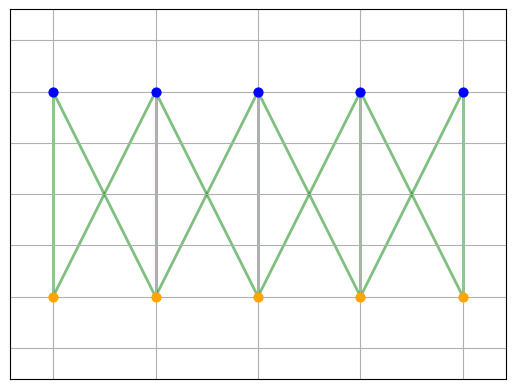

(13, 13)
[[-3.  4.  0.  0.  2. -2. -2. -4.  0.  0.  0.  0.  0.]
 [ 4. -5.  2.  0.  4. -2. -2. -4. -2. -4.  0.  0.  0.]
 [ 0.  2. -5.  4.  4.  0.  0.  0. -2. -4. -2. -4. -2.]
 [ 0.  0.  4. -3.  2.  0.  0.  0.  0.  0. -2. -4. -2.]
 [ 2.  4.  4.  2. -5.  0. -2. -4. -2. -4. -2. -4.  0.]
 [-2. -2.  0.  0.  0.  6.  0.  0.  0.  0.  0.  0.  0.]
 [-2. -2.  0.  0. -2.  0.  6.  4.  0.  0.  0.  0.  0.]
 [-4. -4.  0.  0. -4.  0.  4. 16.  0.  0.  0.  0.  0.]
 [ 0. -2. -2.  0. -2.  0.  0.  0.  6.  4.  0.  0.  0.]
 [ 0. -4. -4.  0. -4.  0.  0.  0.  4. 16.  0.  0.  0.]
 [ 0.  0. -2. -2. -2.  0.  0.  0.  0.  0.  6.  4.  0.]
 [ 0.  0. -4. -4. -4.  0.  0.  0.  0.  0.  4. 16.  0.]
 [ 0.  0. -2. -2.  0.  0.  0.  0.  0.  0.  0.  0.  6.]]


In [1]:
# create qmat
import neal

from data.sp_data import SPData
from models import SPQuboBinary
from evaluation.evaluation import SPEvaluation
from plotting.sp_plot import SPPlot


params = {"version": 1, "num_cols": 5, "rad_max": 2.4}
data = SPData().gen_problem(**params) 
plt = SPPlot(data).plot_problem()
plt.show()

config = {"num_reads":1000,"num_sweeps":1000}
solve_func = neal.SimulatedAnnealingSampler().sample_qubo
qubo_model_bin = SPQuboBinary(data)
qmat = qubo_model_bin.model
print(qmat.shape)
print(qmat)

In [ ]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import qaoa_ansatz
from qiskit.opflow import PauliSumOp
import numpy as np

from qiskit.quantum_info import Operator

from qiskit.circuit.library import QAOAAnsatz

# 1. Define the Cost and Mixer Hamiltonians


# Cost Hamiltonian (Example: H_c = Z0 * Z1 + Z1 * Z2)
cost_hamiltonian = Operator(qmat) # SparsePauliOp(["ZZII", "IIZZ", "ZIIZ"])
print(qmat.shape)
print(cost_hamiltonian.num_qubits)
alpha=1
N=5

mix_hamiltonian = SparsePauliOp(["X"+"I"*(qmat.shape[0]-1), "I"+"I"*(qmat.shape[0]-1), "Z"+"I"*(qmat.shape[0]-1)],  # Pauli strings: Z and X on the first qubit
    coeffs=np.array([1.0,alpha*N/2,-alpha*N/2]))
# 2. Initialize the QAOAAnsatz
p = 10  # Number of layers
qaoa_ansatz = QAOAAnsatz(
    cost_operator=cost_hamiltonian,
    reps=p,
    mixer_operator=mix_hamiltonian
)

# Get the parameters (gammas and betas)
#parameters = qaoa_ansatz.parameters

# Print the circuit
print("QAOA Ansatz Circuit:")
print(qaoa_ansatz.decompose().draw())


from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from scipy.optimize import minimize
# 3. Define the objective function for optimization



def objective_function(params):
    # Bind the parameters (gammas and betas) to the QAOA ansatz
    qc_bound = qaoa_ansatz.assign_parameters(params)
    
    # Simulate the circuit using Statevector
    statevector = Statevector.from_instruction(qc_bound)
    
    # Calculate the expectation value of the cost Hamiltonian
    expectation_value = statevector.expectation_value(cost_hamiltonian)
    
    return expectation_value.real  # We only care about the real part

# 4. Initialize random values for gamma and beta
initial_parameters = np.random.rand(len(qaoa_ansatz.parameters))  # Random initial parameters for gamma and beta

# 5. Use COBYLA from scipy to minimize the objective function
result = minimize(objective_function, initial_parameters, method='COBYLA', options={'maxiter': 100})

# Print the optimized parameters
print("\nOptimized Parameters:")
print(result.x)

# Now we can use the optimized parameters to create the final QAOA circuit
qc_final = qaoa_ansatz.assign_parameters(result.x)

 #Simulate the final circuit
statevector = Statevector.from_instruction(qc_final)

print("\nFinal Statevector:")
print(statevector)

#Calculate and print the probabilities of the final state
probabilities = [abs(amplitude)**2 for amplitude in statevector]
print("\nProbabilities of the final state:")
print(probabilities)

ModuleNotFoundError: No module named 'qiskit.opflow'

In [2]:
#HISTOGRAM DESIGN

import matplotlib.pyplot as plt
import numpy as np

def plot_histogram(probabilities):
    """
    Plots a histogram of quantum state probabilities.

    Parameters:
        probabilities (list): A list of probabilities for each quantum state.
    """
    # Number of qubits (calculated from the length of the probabilities vector: 2^n_qubits)
    n_qubits = int(np.log2(len(probabilities)))

    # Generate the corresponding quantum states
    states = [bin(i)[2:].zfill(n_qubits) for i in range(2**n_qubits)]

    # Create the histogram
    plt.figure(figsize=(12, 6))
    plt.bar(states, probabilities, color='skyblue')

    # Labeling the plot
    plt.xlabel('Quantum States', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.title('Histogram of Quantum State Probabilities', fontsize=14)
    plt.xticks(rotation=90, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()


plot_histogram(probabilities)

NameError: name 'probabilities' is not defined